In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'ml_collections'

In [147]:
# Prepare Model
config = CONFIGS["ViT-S_16"]
config['stochastic'] = True
config['temperature'] = 0.1
device = torch.device("cuda")
model = VisionTransformer(config, num_classes=10, zero_head=False, img_size=32, vis=True)
#model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.load_state_dict(torch.load('./output/svit_head1_layer4_cls_fixed_checkpoint.bin', map_location="cuda:0"))
model.to(device)
model.eval()

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): StochasticAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)

In [160]:
image_path = "img/bird1.jpg"

In [161]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
img = Image.open(image_path)
x = transform(img)
x = x.to(torch.float32).to("cuda")
x.size()

torch.Size([3, 32, 32])

In [162]:
logits, att_mat, sigmas = model(x.unsqueeze(0))

att_mat = np.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = np.mean(att_mat, axis=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = np.eye(att_mat.shape[1])
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / np.expand_dims(aug_att_mat.sum(axis=-1), -1)

# Recursively multiply the weight matrices
joint_attentions = np.zeros(aug_att_mat.shape)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.shape[-1]))
mask = v[0, 1:].reshape(grid_size, grid_size)
mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
result = (mask * img).astype("uint8")

Prediction Label and Attention Map!

0.99334:frog
0.00644:bird
0.00009:cat
0.00007:deer
0.00002:airplane


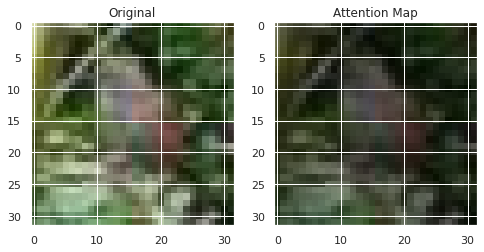

In [163]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f}:{cifar10_labels[idx.item()]}', end='\n')

In [152]:
"""
0 query_idx is for the classification token
"""
layer_idx = 0
query_idx = 64

In [153]:
sigmas_temp = list(map(np.squeeze, sigmas))
for idx, item in enumerate(sigmas_temp[layer_idx]):
    print(f'({idx:2d}, {item: 08.3f})', end=' ')
    if (idx+1)%8==0:
        print()
sigma = sigmas_temp[layer_idx][query_idx]

( 0,  001.987) ( 1,  001.045) ( 2,  001.008) ( 3,  001.018) ( 4,  001.024) ( 5,  001.061) ( 6,  001.024) ( 7,  001.022) 
( 8,  001.018) ( 9,  001.006) (10,  001.022) (11,  001.005) (12,  001.006) (13,  001.015) (14,  001.005) (15,  001.008) 
(16,  001.008) (17,  001.021) (18,  001.033) (19,  001.025) (20,  001.051) (21,  001.032) (22,  001.017) (23,  001.029) 
(24,  001.028) (25,  001.004) (26,  001.002) (27,  001.013) (28,  001.230) (29,  001.043) (30,  001.052) (31,  001.044) 
(32,  001.009) (33,  001.001) (34,  001.000) (35,  001.003) (36,  001.060) (37,  001.001) (38,  001.001) (39,  001.001) 
(40,  001.001) (41,  001.002) (42,  001.003) (43,  001.001) (44,  001.008) (45,  001.003) (46,  001.003) (47,  001.012) 
(48,  001.001) (49,  001.001) (50,  001.001) (51,  001.001) (52,  001.000) (53,  001.001) (54,  001.001) (55,  001.003) 
(56,  001.001) (57,  001.003) (58,  001.009) (59,  001.001) (60,  001.002) (61,  001.001) (62,  001.001) (63,  001.001) 
(64,  001.001) 

In [154]:
n_patches = 8*8
n_rows = n_cols = int(np.sqrt(n_patches))
rows, cols = np.indices((n_rows, n_cols))
token_idxs = np.array(list(zip(rows.flatten(), cols.flatten())))
dists = np.expand_dims(token_idxs, 1) - np.expand_dims(token_idxs,0)
dists = np.pad(dists, ((1,0),(1,0),(0,0)), mode='constant', constant_values=0)
dists = np.sum(dists**2, axis=-1)

norm = 2*sigma**2
kernel = np.exp(-1*dists/norm)

probs = kernel / np.amax(kernel, axis=-1, keepdims=True)
# the first element is always 1 as every token sees the classification token and this is omitted in the plot.
probs_query = np.reshape(probs[query_idx, 1:], (n_rows, n_cols))
probs_query_resized = cv2.resize(probs_query, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)

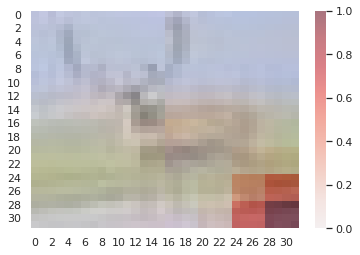

In [155]:
import matplotlib.cm
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.image as mpimg 
import seaborn as sns; sns.set()

map_img = mpimg.imread(image_path) 
hmax = sns.heatmap(probs_query_resized,
            cmap=plt.cm.Reds,
            alpha = 0.5,
            annot = False,
            zorder = 2,
            )

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap

plt.show()

In [134]:
with np.printoptions(precision=3, suppress=True):
    print(probs_query)

[[0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.002 0.007 0.011]
 [0.    0.    0.    0.    0.002 0.018 0.082 0.136]
 [0.    0.    0.    0.    0.007 0.082 0.368 0.607]
 [0.    0.    0.    0.    0.011 0.136 0.607 1.   ]]


In [22]:
sigmas_rand = torch.tensor([1,5,-0.5]).repeat([3,1,65,1]).to(torch.float32)

In [23]:
a = torch.tensor([[1,0],[0,0]]).repeat([*sigmas_rand.shape[:-1], 1,1]) * sigmas_rand[...,0,None,None]**2
b = torch.tensor([[0,0],[0,1]]).repeat([*sigmas_rand.shape[:-1], 1,1]) * sigmas_rand[...,1,None,None]**2
c = torch.tensor([[0,1],[1,0]]).repeat([*sigmas_rand.shape[:-1], 1,1]) * sigmas_rand[...,2,None,None]*sigmas_rand[...,0,None,None]*sigmas_rand[...,1,None,None]
sigmas_inverse = torch.linalg.pinv(a+b+c)
print(sigmas_inverse.shape)

torch.Size([3, 1, 65, 2, 2])


In [174]:
n_patches = 8*8
n_rows = n_cols = int(np.sqrt(n_patches))
rows, cols = np.indices((n_rows, n_cols))
token_idxs = np.array(list(zip(rows.flatten(), cols.flatten())))
dists = np.expand_dims(token_idxs, 1) - np.expand_dims(token_idxs,0)
dists = np.pad(dists, ((1,0),(1,0),(0,0)), mode='constant', constant_values=0)

# kernel = torch.exp(-1/2 * (dists.permute([0,1,3,2]) @ sigma_inverse @ dists).squeeze())
dists = torch.tensor(dists).to(torch.float32).repeat([3,1,1,1,1])
dists = torch.unsqueeze(dists, -1)

[[5 5]
 [7 7]
 [7 6]
 [7 5]
 [7 4]
 [7 3]
 [7 2]
 [7 1]
 [7 0]
 [6 7]
 [6 6]
 [6 5]
 [6 4]
 [6 3]
 [6 2]
 [6 1]
 [6 0]
 [5 7]
 [5 6]
 [5 5]
 [5 4]
 [5 3]
 [5 2]
 [5 1]
 [5 0]
 [4 7]
 [4 6]
 [4 5]
 [4 4]
 [4 3]
 [4 2]
 [4 1]
 [4 0]
 [3 7]
 [3 6]
 [3 5]
 [3 4]
 [3 3]
 [3 2]
 [3 1]
 [3 0]
 [2 7]
 [2 6]
 [2 5]
 [2 4]
 [2 3]
 [2 2]
 [2 1]
 [2 0]
 [1 7]
 [1 6]
 [1 5]
 [1 4]
 [1 3]
 [1 2]
 [1 1]
 [1 0]
 [0 7]
 [0 6]
 [0 5]
 [0 4]
 [0 3]
 [0 2]
 [0 1]
 [0 0]]


In [25]:
sigmas_inverse_temp = sigmas_inverse.unsqueeze(3).repeat([1,1,1,65,1,1])
print(sigmas_inverse_temp.shape)

torch.Size([3, 1, 65, 65, 2, 2])


In [26]:
weights = -1/2 * torch.matmul(torch.matmul(dists.permute([0,1,2,3,5,4]), sigmas_inverse_temp), dists)
weights = weights.view(weights.shape[:-2])
weights_stable = weights - torch.amax(weights, dim=[-1], keepdim=True)
kernel = torch.exp(weights_stable)

In [27]:
probs = kernel / torch.amax(kernel, dim=[-1], keepdim=True)
probs_query = np.reshape(probs[0,0, 30, 1:].numpy(), (n_rows, n_cols))
probs_query_resized = cv2.resize(probs_query, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)

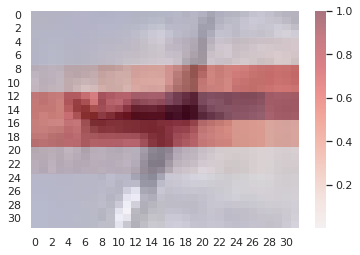

In [679]:
import matplotlib.cm
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.image as mpimg 
import seaborn as sns; sns.set()

map_img = mpimg.imread(image_path) 
hmax = sns.heatmap(probs_query_resized,
            cmap=plt.cm.Reds,
            alpha = 0.5,
            annot = False,
            zorder = 2,
            )

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap

plt.show()

In [664]:
with np.printoptions(precision=3, suppress=True):
    print(probs_query)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [665]:
probs[0,0]

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.9380e-30,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6042e-28,
         1.0000e+00],
        ...,
        [0.0000e+00, 1.0000e+00, 8.7578e-27,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.6042e-28,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 2.9380e-30,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])